In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
plt.style.use('default')
import riiideducation

_ = np.seterr(divide='ignore', invalid='ignore')

---
# Import

In [3]:
data_types_dict = {                 
    'user_id': 'int32', 
    'content_id': 'int16',
    'task_container_id': 'int16',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}

target = 'answered_correctly'

In [4]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv',
                    columns=set(data_types_dict.keys())).to_pandas()
                    
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

In [5]:
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,1,1,NaN,False
1,115,5716,2,1,37000.0,False
2,115,128,0,1,55000.0,False
3,115,7860,3,1,19000.0,False
4,115,7922,4,1,11000.0,False


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 6 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
dtypes: bool(1), float32(1), int16(2), int32(1), int8(1)
memory usage: 1.3 GB


---
# Extraction des données de validation
## Construction de la table des interactions des utilisateurs

In [7]:
user_info = train_df.groupby('user_id')['content_id'].count().sort_values(ascending=False).reset_index()
user_info = user_info.rename(columns={'content_id':'nb_interactions'})
user_info

,user_id,nb_interactions
0,801103753,17917
1,1478712595,16914
2,1842816145,16851
3,455973631,16789
4,1660941992,16777
...,...,...
393651,1632816630,1
393652,1946651368,1
393653,118250768,1
393654,594429989,1



## Compréhension du volume d'interactions

In [8]:
# Loi de Pareto 80/20
tresh = 80
idx = int(len(user_info) * tresh / 100)
min_interaction = user_info.at[idx, 'nb_interactions']
print(f'{tresh} % des utilisateurs ont au moins {min_interaction} interactions')

80 % des utilisateurs ont au moins 26 interactions


En appliquant la loi de Pareto, je me rend compte que 80% des utilisateurs ont au moins 26 interactions. Je me servirai de cette base pour entraîner mon modèle. Je dois nettoyer les utilisateurs ne rentrant pas dans le cadre de 80%, c'est à dire avec moins de 26 interactions.

Je me servira d'environ 25 % des dernières interactions utilisateurs pour valider le modèle, puisqu'il y a une certaine chonologie dans les actions de ces derniers.
Les 6 dernières lignes de chaque utilisateurs devient le jeu de validation. Je les extraits dans une nouvelle table avant de procéder à la transformation de certaines variables.

In [9]:
val_size = int(min_interaction * 0.25)
print(f"Taille des interactions de validation par utilisateurs : {val_size}")

Taille des interactions de validation par utilisateurs : 6


In [10]:
user_info = user_info[user_info.nb_interactions >= min_interaction]
#user_info = user_info[user_info.nb_interactions >= val_size]
user_info

,user_id,nb_interactions
0,801103753,17917
1,1478712595,16914
2,1842816145,16851
3,455973631,16789
4,1660941992,16777
...,...,...
316088,1047453739,26
316089,433640427,26
316090,1477417687,26
316091,634165303,26


In [11]:
# train_df = pd.merge(train_df, user_info, on='user_id')
# train_df

In [12]:
valid_df = train_df.groupby('user_id').tail(val_size)
train_df.drop(valid_df.index, inplace=True)

---
# Features engineering

In [13]:
help_usage = train_df[train_df[target] == -1].groupby('user_id')['content_id'].count()
help_usage = help_usage.reset_index().rename(columns={'content_id': 'help_usage'})

help_usage['binned_help_usage'] = pd.cut(help_usage['help_usage'],
                                         bins=[-np.inf, 0, 1, 3, np.inf],
                                         labels=[0, 1, 2, 3])
                                         
help_usage.drop(columns=['help_usage'], inplace=True)
help_usage

,user_id,binned_help_usage
0,2746,1
1,5382,2
2,8623,2
3,12741,3
4,13134,3
...,...,...
140177,2147419988,3
140178,2147469944,2
140179,2147470770,2
140180,2147470777,3


In [14]:
train_df = pd.merge(train_df,
                    help_usage,
                    on='user_id',
                    how='left')
                    
train_df.binned_help_usage = train_df.binned_help_usage.fillna(0).astype('int')
train_df

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,binned_help_usage
0,115,5692,1,1,NaN,False,0
1,115,5716,2,1,37000.0,False,0
2,115,128,0,1,55000.0,False,0
3,115,7860,3,1,19000.0,False,0
4,115,7922,4,1,11000.0,False,0
...,...,...,...,...,...,...,...
98869341,2147482888,4425,16,0,26000.0,True,0
98869342,2147482888,5005,17,0,30000.0,True,0
98869343,2147482888,8711,18,0,9000.0,True,0
98869344,2147482888,5591,19,1,26000.0,True,0


In [15]:
train_df = train_df[train_df[target] != -1].reset_index(drop=True)

---
# Target encoding

In [16]:
# Calcul du taux de réussite de l'utilisateur en fonction de son avancée
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

In [17]:
# Je compte le nombre de bonnes réponses par utilisateurs et 
# Je compte le nombre de réponses par utilsateurs (juste ou fausse)
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])

# Je compte le nombre de bonnes réponses par contenu et
# Je compte le nombres de réponses par contenu (juste ou fausse)
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [18]:
# Récupération des 24 dernières interactions de chaque utilisateur (- les donnée de val)
train_df = train_df.groupby('user_id').tail(min_interaction - val_size).reset_index(drop=True)

In [19]:
# Récupération des parts du TOEIC
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)

# Catégorisation Listening (0) ou Reading (1)
questions_df['L_R'] = pd.cut(questions_df['part'],
                             bins=[-np.inf, 4, np.inf],
                             labels=[True, False])

train_df = pd.merge(train_df,
                    questions_df,
                    left_on='content_id',
                    right_on='question_id',
                    how='left')
                    
train_df.L_R = train_df.L_R.astype('bool')
train_df.drop(columns=['question_id'], inplace=True)

In [20]:
# J'intègre le nombre d'apparitions totales de chaque contenu sur leurs lignes respectives
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')

# Je transforme content_id en taux de réussite par contenu
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

In [21]:
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,binned_help_usage,user_correctness,part,L_R,content_count
0,115,0.613906,20,0,29000.0,False,0,0.800000,1,True,31469
1,115,0.676134,21,0,20000.0,False,0,0.761905,1,True,25983
2,115,0.687624,22,0,19000.0,False,0,0.727273,1,True,36344
3,115,0.609106,23,0,21000.0,False,0,0.695652,1,True,46565
4,115,0.603051,24,1,22000.0,False,0,0.666667,1,True,40116


---
## Inférence sur valid_df

In [22]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [23]:
valid_df = valid_df[valid_df[target] != -1].reset_index(drop=True)

In [24]:
valid_df = pd.merge(valid_df,
                    help_usage,
                    on='user_id',
                    how='left')
                    
valid_df.binned_help_usage = valid_df.binned_help_usage.fillna(0).astype('int')
valid_df

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,binned_help_usage
0,115,2065,40,1,17000.0,False,0
1,115,2064,40,1,17000.0,False,0
2,115,2063,40,0,17000.0,False,0
3,115,3363,41,0,14333.0,False,0
4,115,3365,41,0,14333.0,False,0
...,...,...,...,...,...,...,...
2329327,2147482888,3586,22,1,18000.0,True,0
2329328,2147482888,6341,23,1,14000.0,True,0
2329329,2147482888,4212,24,1,14000.0,True,0
2329330,2147482888,6343,25,0,22000.0,True,0


In [25]:
valid_df = pd.merge(valid_df,
                    questions_df,
                    left_on='content_id',
                    right_on='question_id',
                    how='left')
                    
valid_df.L_R = valid_df.L_R.astype('bool')
valid_df

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,binned_help_usage,question_id,part,L_R
0,115,2065,40,1,17000.0,False,0,2065,3,True
1,115,2064,40,1,17000.0,False,0,2064,3,True
2,115,2063,40,0,17000.0,False,0,2063,3,True
3,115,3363,41,0,14333.0,False,0,3363,4,True
4,115,3365,41,0,14333.0,False,0,3365,4,True
...,...,...,...,...,...,...,...,...,...,...
2329327,2147482888,3586,22,1,18000.0,True,0,3586,5,False
2329328,2147482888,6341,23,1,14000.0,True,0,6341,5,False
2329329,2147482888,4212,24,1,14000.0,True,0,4212,5,False
2329330,2147482888,6343,25,0,22000.0,True,0,6343,5,False


In [26]:
valid_df['prior_question_had_explanation'] = valid_df['prior_question_had_explanation'].fillna(False).astype('bool')

In [27]:
user_sum = np.zeros(len(valid_df), dtype=np.int16)
user_count = np.zeros(len(valid_df), dtype=np.int16)
content_sum = np.zeros(len(valid_df), dtype=np.int32)
content_count = np.zeros(len(valid_df), dtype=np.int32)

for i, (user_id, content_id) in enumerate(zip(valid_df['user_id'].values, valid_df['content_id'].values)):
    user_sum[i] = user_sum_dict[user_id]
    user_count[i] = user_count_dict[user_id]
    content_sum[i] = content_sum_dict[content_id]
    content_count[i] = content_count_dict[content_id]

In [28]:
valid_df['user_correctness'] = user_sum / user_count
valid_df['content_count'] = content_count
valid_df['content_id'] = content_sum / content_count

In [29]:
valid_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,binned_help_usage,question_id,part,L_R,user_correctness,content_count
0,115,0.633624,40,1,17000.0,False,0,2065,3,True,0.725,175077
1,115,0.636909,40,1,17000.0,False,0,2064,3,True,0.725,175094
2,115,0.163048,40,0,17000.0,False,0,2063,3,True,0.725,175102
3,115,0.280868,41,0,14333.0,False,0,3363,4,True,0.725,167990
4,115,0.302380,41,0,14333.0,False,0,3365,4,True,0.725,167964


---
# Train

In [30]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count',
    'L_R',
    'binned_help_usage'
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

In [31]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

model = lgb.train(
    params, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.75154	valid_1's auc: 0.731844
[100]	training's auc: 0.75313	valid_1's auc: 0.733768
[150]	training's auc: 0.753817	valid_1's auc: 0.73442
[200]	training's auc: 0.754173	valid_1's auc: 0.734638
[250]	training's auc: 0.754448	valid_1's auc: 0.734774
[300]	training's auc: 0.754726	valid_1's auc: 0.734937
[350]	training's auc: 0.754968	valid_1's auc: 0.73505
[400]	training's auc: 0.755198	valid_1's auc: 0.735146
[450]	training's auc: 0.755432	valid_1's auc: 0.73525
[500]	training's auc: 0.755642	valid_1's auc: 0.735317
[550]	training's auc: 0.755868	valid_1's auc: 0.735398
[600]	training's auc: 0.756073	valid_1's auc: 0.735465
[650]	training's auc: 0.756273	valid_1's auc: 0.735522
[700]	training's auc: 0.756468	valid_1's auc: 0.735573
[750]	training's auc: 0.756649	valid_1's auc: 0.735611
[800]	training's auc: 0.756836	valid_1's auc: 0.735655
[850]	training's auc: 0.757018	valid_1's auc: 0.735688
[900]	trai

In [32]:
# model = lgb.Booster(model_file='../input/model-compet/model.txt')

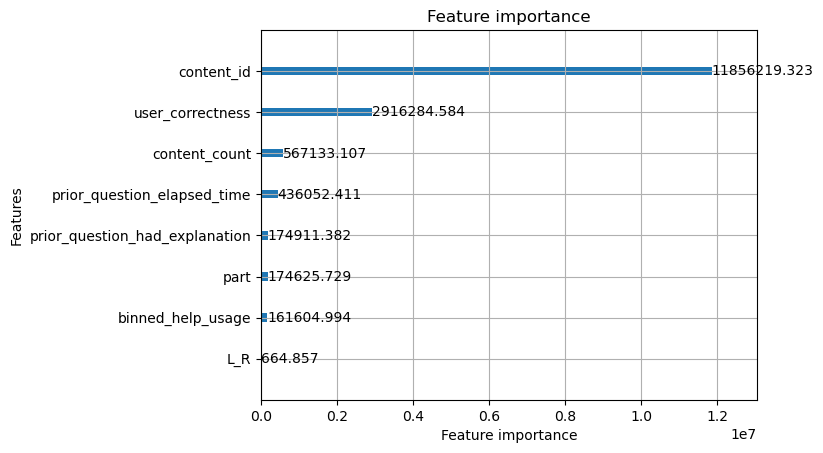

In [33]:
lgb.plot_importance(model, importance_type='gain')
plt.savefig('./img_feature_importances.png',
            transparent=True)
plt.show()

In [34]:
valid_df["target"] = model.predict(valid_df[features])
valid_df

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,binned_help_usage,question_id,part,L_R,user_correctness,content_count,target
0,115,0.633624,40,1,17000.0,False,0,2065,3,True,0.72500,175077,0.679776
1,115,0.636909,40,1,17000.0,False,0,2064,3,True,0.72500,175094,0.675695
2,115,0.163048,40,0,17000.0,False,0,2063,3,True,0.72500,175102,0.160288
3,115,0.280868,41,0,14333.0,False,0,3363,4,True,0.72500,167990,0.344606
4,115,0.302380,41,0,14333.0,False,0,3365,4,True,0.72500,167964,0.351846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329327,2147482888,0.741860,22,1,18000.0,True,0,3586,5,False,0.47619,4269,0.623609
2329328,2147482888,0.527227,23,1,14000.0,True,0,6341,5,False,0.47619,10045,0.406864
2329329,2147482888,0.617869,24,1,14000.0,True,0,4212,5,False,0.47619,30589,0.533529
2329330,2147482888,0.662886,25,0,22000.0,True,0,6343,5,False,0.47619,5642,0.520344


# Inference

In [35]:
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [36]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    # Extraction des données du test_df précédent
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        # Récupération des valeurs
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        # Intégration dans un dictionnaire
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1
    
    # Copie du test_df pour réutilisation
    prior_test_df = test_df.copy()
    
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    
    test_df = pd.merge(test_df, help_usage, on='user_id', how='left')
    test_df.binned_help_usage = test_df.binned_help_usage.fillna(0).astype('int')
    
    test_df = pd.merge(test_df,
                       questions_df,
                       left_on='content_id',
                       right_on='question_id',
                       how='left')
                       
    test_df.L_R = test_df.L_R.astype('bool')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
       
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 1.75 s, sys: 136 ms, total: 1.88 s
Wall time: 961 ms


In [37]:
test_df[features]

,content_id,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count,L_R,binned_help_usage
0,0.637274,15000.0,False,0.666667,5,5194,False,0
1,0.735011,19000.0,True,0.644805,2,32941,True,3
2,0.411971,26333.0,True,0.818052,7,3141,False,3
3,0.861191,26333.0,True,0.818052,7,3141,False,3
4,0.457962,26333.0,True,0.818052,7,3140,False,3
5,0.332697,26333.0,True,0.818052,7,3141,False,3
6,0.808599,26333.0,True,0.818052,7,3140,False,3
7,0.649877,19000.0,True,0.668083,5,3653,False,3
8,0.436318,10000.0,True,0.668272,5,18239,False,3
9,0.709877,28750.0,True,0.806140,1,162,True,3


In [38]:
test_df[['row_id', target]]

,row_id,answered_correctly
0,74,0.592028
1,75,0.728926
2,76,0.617505
3,77,0.961903
4,78,0.662412
5,79,0.565493
6,80,0.928917
7,81,0.649239
8,82,0.454236
9,84,0.766253
